In [1]:
#Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from tia.bbg import LocalTerminal
from pandas.tseries.offsets import *
from sklearn import decomposition
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
import sklearn.mixture as mix
import statsmodels.api as sm
#import networkx as nx
#from pprint import pprint 

import numpy as np
import scipy.stats as scs

import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
%matplotlib inline

#import seaborn as sns


In [2]:
# Getting BBG data and cleaning
StartDate = '1995-12-30'
EndDate = (dt.datetime.today()-BDay(1)).strftime("%m/%d/%Y")

Dates = pd.DataFrame(pd.date_range(StartDate,EndDate,freq="D"),columns=['Date'])
Dates = Dates.set_index('Date',drop=True)
Dates.index.name = None

Month = pd.DataFrame(pd.date_range(StartDate,EndDate,freq="M"),columns=['Date'])
Month = Month.set_index('Date',drop=True)
Month.index.name = None

Quarter = pd.DataFrame(pd.date_range(StartDate,EndDate,freq="Q"),columns=['Date'])
Quarter = Quarter.set_index('Date',drop=True)
Quarter.index.name = None

In [3]:
# Take EPI data from excel

# Read EPI
JPYEPIEx = pd.ExcelFile('M:\FXNEW\FX Model v clean THIS ONE\Regime Scorecard\QuantMacroRegime\MacroRegEPI.xlsx').parse('MacroRegEPI')
JPYEPIEx.index = JPYEPIEx['Date']
JPYEPIEx = JPYEPIEx.drop(columns = ['Date'])
JPYEPIEx = JPYEPIEx.fillna(method='ffill')
JPYEPIEx = Dates.merge(JPYEPIEx,right_index=True,left_index=True,how='left')
JPYEPIEx = JPYEPIEx.fillna(method='ffill')
JPYEPIEx = Month.merge(JPYEPIEx,right_index=True,left_index=True,how='left')

In [4]:
JPYEPIEx.tail()

EpiM_Headline_AU  EpiM_Business_AU  EpiM_Consumer_AU  \
2019-08-31         -1.201616         -0.810514         -1.547828   
2019-09-30         -1.122207         -0.709136         -0.904735   
2019-10-31         -1.152160         -0.680101         -0.742778   
2019-11-30         -1.093602         -0.386141         -0.380259   
2019-12-31         -0.955334         -0.722078         -0.376885   

            EpiM_Employment_AU  EpiM_Growth_AU  EpiM_Inflation_AU  \
2019-08-31           -0.238016       -1.173196          -0.109109   
2019-09-30           -0.289336       -1.264090          -0.267672   
2019-10-31           -0.422667       -1.250853          -0.378492   
2019-11-30           -0.878802       -1.183764          -0.398445   
2019-12-31           -0.134679       -1.090942          -0.406488   

            EpiM_Headline_NZ  EpiM_Business_NZ  EpiM_Consumer_NZ  \
2019-08-31          0.130303         -1.020304         -0.354152   
2019-09-30         -0.030897         -1.206799         -0.276482   
2019-10-31         -0.095115         -1.216050         -0.208466   
2019-11-30          0.181349         -0.630998          0.170338   
2019-12-31          0.663546         -0.369224          0.546356   

            EpiM_Employment_NZ  ...  EpiM_Consumer_UK  EpiM_Employment_UK  \
2019-08-31            1.438950  ...          0.072789            0.177752   
2019-09-30            1.428814  ...          0.009009            0.166787   
2019-10-31            1.398130  ...          0.066458            0.229262   
2019-11-30            1.078143  ...         -0.075605            0.062089   
2019-12-31            1.072784  ...         -0.109736            0.071851   

            EpiM_Growth_UK  EpiM_Inflation_UK  EpiM_Headline_Global  \
2019-08-31       -0.536816          -0.801183             -0.469911   
2019-09-30       -0.535227          -0.380680             -0.325728   
2019-10-31       -0.531307          -0.945866             -0.447875   
2019-11-30       -0.077558          -1.271533             -0.525725   
2019-12-31        0.009556          -0.794296             -0.520160   

            EpiM_Business_Global  EpiM_Consumer_Global  \
2019-08-31             -0.711712             -0.442848   
2019-09-30             -0.614337             -0.283837   
2019-10-31             -0.703352             -0.306907   
2019-11-30             -0.716446             -0.368442   
2019-12-31             -1.026876             -0.476515   

            EpiM_Employment_Global  EpiM_Growth_Global  EpiM_Inflation_Global  
2019-08-31                0.199673           -0.326406              -0.337889  
2019-09-30                0.404698           -0.305914              -0.347894  
2019-10-31                0.302243           -0.377753              -0.475776  
2019-11-30                0.171067           -0.458164              -0.393423  
2019-12-31                0.304541           -0.554854               0.096949  

[5 rows x 42 columns]

In [5]:
# Take Bloomberg data from excel

# Read Bloomberg Data
Ecodata = pd.ExcelFile('M:\FXNEW\FX Model v clean THIS ONE\Regime Scorecard\QuantMacroRegime\MacroRegBBGUpdate.xlsx').parse('Month')
Ecodata = Ecodata.iloc[2:]
Ecodata.index = Ecodata['NAME']
Ecodata = Ecodata.drop(columns = ['NAME'])
Ecodata = Ecodata.fillna(method='ffill')
Ecodata = Dates.merge(Ecodata,right_index=True,left_index=True,how='left')
Ecodata = Ecodata.fillna(method='ffill')
Ecodata = Month.merge(Ecodata,right_index=True,left_index=True,how='left')


# Read in half-yearly bak NIMs
BankData1 = pd.ExcelFile('M:\FXNEW\FX Model v clean THIS ONE\Regime Scorecard\QuantMacroRegime\MacroRegBBGUpdate.xlsx').parse('Quarter')
BankData1 = BankData1.iloc[1:]
BankData1.index = BankData1['Unnamed: 0']
BankData1 = BankData1.drop(columns = ['Unnamed: 0'])
BankData1 = BankData1.fillna(method='ffill')
BankData1 = Dates.merge(BankData1,right_index=True,left_index=True,how='left')
BankData1 = BankData1.fillna(method='ffill')
BankData1 = Month.merge(BankData1,right_index=True,left_index=True,how='left')
Ecodata = Ecodata.merge(BankData1,right_index=True,left_index=True,how='left')

#Read in quarterly Bank NIMs
BankData2 = pd.ExcelFile('M:\FXNEW\FX Model v clean THIS ONE\Regime Scorecard\QuantMacroRegime\MacroRegBBGUpdate.xlsx').parse('BiAnn')
BankData2 = BankData2.iloc[1:]
BankData2.index = BankData2['Unnamed: 0']
BankData2 = BankData2.drop(columns = ['Unnamed: 0'])
BankData2 = BankData2.fillna(method='ffill')
BankData2 = Dates.merge(BankData2,right_index=True,left_index=True,how='left')
BankData2 = BankData2.fillna(method='ffill')
BankData2 = Month.merge(BankData2,right_index=True,left_index=True,how='left')
Ecodata = Ecodata.merge(BankData2,right_index=True,left_index=True,how='left')

In [9]:
# Put the codes in 

NamesIdx = ['EPI ex inflation M','EPI ex inflation L','EPI Synchronised Sectors or Regions M','EPI Synchronised Sectors or Regions L',
'Earnings Growth M','Earnings Growth L','Investment/Capex M','Investment/Capex L','Credit Growth M',
'Credit Growth L','Inventory Cycle M',
'Inventory Cycle L','Global Trade M','Global Trade L','Fiscal Impulse M','Fiscal Impulse L',
'EPI Inflation M','EPI Inflation L','Wage Inflation M','Wage Inflation L','Core (Persistence/Breadth) M',
'Core (Persistence/Breadth) L','OECD Output Gap M','OECD Output Gap L','Employment EPI M',
'Employment EPI L','Unemployment level vs NAIRU M','Unemployment level vs NAIRU L',
'Capacity Utilisation M','Capacity Utilisation L','Property (1y momentum) M','Property (level) L',
'Equities M','Equities L','Household Leverage M','Household Leverage L','Corporate Leverage M',
'Corporate Leverage L','Government Leverage M','Government Leverage L',
'Public Sector Liquidity ==> Reserves, Central Bank BS M','Public Sector Liquidity ==> Reserves, Central Bank BS L',
'Private Sector Liquidity ==> Banking System Liquidity (Broader monetary aggregates, Shadow bank liquidity) M',
'Private Sector Liquidity ==> Banking System Liquidity (Broader monetary aggregates, Shadow bank liquidity) L',
'Cross Border Liquidity ==> CA Surpluses, Petrodollar flows, EM flows etc M',
'Cross Border Liquidity ==> CA Surpluses, Petrodollar flows, EM flows etc L',
'Real Policy Rate vs real neutral rate M','Real Policy Rate vs real neutral rate L','Real Long End Yields M',
'Real Long End Yield L','Real Ccy vs ToT M','Real Ccy vs ToT L','Financial Sector Health M',
'Financial Sector Health L','Credit Spreads M','Credit Spreads L']

CodesIdx = ['TPX Index BEPS','TPX Index PE','JNIPYOY Index','JPALDBLB Index','JNVSIVTS Index','JNTBAL Index','JNTBEXP Index','JNTBIMP Index',
'EHBBJPY Index','JGDPPBDY Index','JGDPGC Index','JNLSUCTL Index','JCPNEFEY Index','JCPTEFEY Index','JNOPOUTG Index',
'JNUE Index','JNCAP Index','JHPITNAT Index','JBKOCM Index','CPNFJPHG Index','CPNFJPA3 Index','JHHSDINM Index',
'CPNFJPNG Index','CPNFJPOG Index','FARBCRED Index','EBBSTOTA Index','EURUSD Curncy','BJACTOTL Index','JPYUSD Curncy',
'CNBMTTAS Index','CNYUSD Curncy','JNMBMOB Index','JMNSBLQY Index','JMNSM3Y Index','JMNSM1Y Index','USCABAL Index',
'ECOCEAS Index','ECOCJPN Index','ECOCCNN Index','BOJDPBAL Index','JYGGBE05 Index','JNCPIYOY Index','USNREUAR Index',
'USNRUS Index','GJGB10 Index','158.028 Index','CTOTJPY Index','TPNBNK Index','8306 JT Equity','8316 JT Equity',
'8411 JT Equity','8309 JT Equity','LGJ1OAS Index']

#Recopy CodesIdx and CodesNames Idx as added things for Japan along the way

In [10]:
CodesNamesIdx = ['TOPIX INDEX (TOKYO)','Japan Indices of Industrial Pr','JP Domestically Licensed Banks',
'Japan Inventories to Sales Rat','Japan Trade Statistics Balance','Japan Merchandise Trade Export',
'Japan Merchandise Trade Import','Japan Budget Balance (% GDP)','Japan GDP Chained Real Public',
'Japan GDP Chained Real Price G','Japan Labour Statistics Avg Mo','Japan CPI Nationwide Ex Food &','Japan CPI Tokyo Ex Food & Ener',
'Japan Output Gap','Japan Unemployment Rate SA','Japan Capacity Utilization Ope','Japan House Price Index All Ja',
'TOPIX INDEX (TOKYO)','Japan Banks Senior Officer Sur','BIS Japan Credit to Households','Japan Total Credit to Househol',
'Japan HH Spend Two-or-more-per','BIS Japan Credit to Non Financ','BIS Japan Credit to General Go',
'US Factors Supplying Reserve F','ECB Balance Sheet All Assets','EUR-USD X-RATE','Bank of Japan assets:Total',
'JPY-USD X-RATE','China Central Bank Balance She','CNY-USD X-RATE','BOJ Monetary Base Avg Outstand','Japan Money Stock Broadly-defi',
'Japan Money Stock M3 avg amt o','Japan Money Stock M1 avg amt o','US Nominal Account Balance In','Eurozone Current Account Balan',
'Japan Current Account Balance','China Current Account Balance','Bank Of Japan Policy-Rate Bala','Japan Breakeven 5 Year',
'Japan CPI Nationwide YoY','Laubach Williams Natural Rate','Laubach Williams Natural Rate','Japan Generic Govt 10Y Yield',
'IMF Japan Real Effective Excha','Citi Terms of Trade Index - Ja','TOPIX BANKS INDEX','MITSUBISHI UFJ FINANCIAL GRO',
'SUMITOMO MITSUI FINANCIAL GR','MIZUHO FINANCIAL GROUP INC','SUMITOMO MITSUI TRUST HOLDIN','Bloomberg Barclays Global Japa',]


In [11]:
#Copies and Adjustments

#Main Code df
RegCode = pd.DataFrame(0,index=Month.index, columns=NamesIdx)
PXLast = pd.DataFrame(0,index=Month.index, columns=['Blank'])
for i in CodesIdx:
    PXLast = PXLast.merge(pd.DataFrame(Ecodata[[i]]),right_index=True,left_index=True,how='left')
PXLast = PXLast.drop(columns=['Blank'])

#Add in EPI
PXLast['EpiM_Headline_JN'] = JPYEPIEx['EpiM_Headline_JN'].copy()
PXLast['EpiM_Business_JN'] = JPYEPIEx['EpiM_Business_JN'].copy()
PXLast['EpiM_Consumer_JN'] = JPYEPIEx['EpiM_Consumer_JN'].copy()
PXLast['EpiM_Employment_JN'] = JPYEPIEx['EpiM_Employment_JN'].copy()
PXLast['EpiM_Growth_JN'] = JPYEPIEx['EpiM_Growth_JN'].copy()
PXLast['EpiM_Inflation_JN'] = JPYEPIEx['EpiM_Inflation_JN'].copy()



In [13]:
# Start adjusting data series

#YOY%
PXLast['JPALDBLB Index'] = (PXLast['JPALDBLB Index']/PXLast['JPALDBLB Index'].shift(12) -1)
PXLast['JNTBEXP Index'] = (PXLast['JNTBEXP Index']/PXLast['JNTBEXP Index'].shift(12) -1)
PXLast['JNTBIMP Index'] = (PXLast['JNTBIMP Index']/PXLast['JNTBIMP Index'].shift(12) -1)
PXLast['JGDPGC Index'] = (PXLast['JGDPGC Index']/PXLast['JGDPGC Index'].shift(12) -1)
PXLast['JHPITNAT Index'] = (PXLast['JHPITNAT Index']/PXLast['JHPITNAT Index'].shift(12) -1)
#AU code has state and local, general government expenditure and general govt gross fixed capital formation'
#Could only find general govt expenditure for Japan'
#PXLast['JNLSUCTL Index'] = (PXLast['JNLSUCTL Index']/PXLast['JNLSUCTL Index'].shift(12) -1) - already YOY%


# Unemployment vs NAIRU estimate of 3.4% for Japan
PXLast['JNUE Index'] = (PXLast['JNUE Index'] - 3.4)
#Using historical average of OEEOJPUQ Index - OECD's estimate of NAIRU for Japan, back to 1985

# Inverse for unemployment, fiscal and debt, credit spreads
PXLast['JNUE Index'] = -1*PXLast['JNUE Index']
PXLast['EHBBJPY Index'] = -1*PXLast['EHBBJPY Index']
PXLast['CPNFJPHG Index'] = -1*PXLast['CPNFJPHG Index']
PXLast['CPNFJPNG Index'] = -1*PXLast['CPNFJPNG Index']
PXLast['CPNFJPOG Index'] = -1*PXLast['CPNFJPOG Index']
PXLast['LGJ1OAS Index'] = -1*PXLast['LGJ1OAS Index']

# Quarterly Sum for inventories, 12M sum for trade balance
PXLast['JNVSIVTS Index'] = PXLast['JNVSIVTS Index'].rolling(4).sum()
PXLast['JNTBAL Index'] = PXLast['JNTBAL Index'].rolling(12).sum()

# Household debt as % of income
PXLast['CPNFJPA3 Index'] = (PXLast['CPNFJPA3 Index']/(PXLast['JHHSDINM Index']/1000)) #HH income adj for blns
#Not sure on JHHSDINC Index but all I could find

# Central Bank Balance sheet, convert all CB B/S to USD and Sum
PXLast['FARBCRED Index'] = ((PXLast['FARBCRED Index']/1000)+(PXLast['EBBSTOTA Index']*PXLast['EURUSD Curncy'])
                            +(PXLast['BJACTOTL Index']*PXLast['JPYUSD Curncy'])
                            +(PXLast['CNBMTTAS Index']*PXLast['CNYUSD Curncy']))                            
                            
# Current Account Balance G4 Sums
PXLast['USCABAL Index'] = PXLast['USCABAL Index']+PXLast['ECOCEAS Index']+PXLast['ECOCJPN Index']+PXLast['ECOCCNN Index']

# Real Rate Calcs policy and long end, and vs neutral rate for policy
PXLast['GJGB10 Index'] = ((PXLast['JYGGBE05 Index']+PXLast['JNCPIYOY Index'])/2 
                           - PXLast['GJGB10 Index'])#Real long end
PXLast['BOJDPBAL Index'] = -1*((PXLast['BOJDPBAL Index'] - (PXLast['JYGGBE05 Index']+PXLast['JNCPIYOY Index'])/2)
                          -(0.3*PXLast['USNRUS Index']+0.6*PXLast['USNREUAR Index']
                          +0.1*PXLast['GJGB10 Index'].rolling(12).mean())) #Real policy rate
#Leave US and EU natural rate for Japan as well?

# Real currency v Terms of trade
PXLast['158.028 Index'] = PXLast['CTOTJPY Index']/PXLast['158.028 Index']



In [14]:
# Z-scoring at different time frames

# 0.5Y
PXLast05Yzs = (PXLast - PXLast.rolling(6).mean())/PXLast.rolling(6).std()

#1y
PXLast1Yzs = (PXLast - PXLast.rolling(12).mean())/PXLast.rolling(12).std()

#3Y
PXLast3Yzs = (PXLast - PXLast.rolling(3*12).mean())/PXLast.rolling(3*12).std()

#5y
PXLast5Yzs = (PXLast - PXLast.rolling(5*12).mean())/PXLast.rolling(5*12).std()

#7Y
PXLast7Yzs = (PXLast - PXLast.rolling(7*12).mean())/PXLast.rolling(7*12).std()

#10Y
PXLast10Yzs = (PXLast - PXLast.rolling(10*12).mean())/PXLast.rolling(10*12).std()


In [15]:
# Add in Adjusted Series
#Growth
RegCode['EPI ex inflation M'] = PXLast05Yzs['EpiM_Headline_JN']
RegCode['EPI ex inflation L'] = PXLast5Yzs['EpiM_Headline_JN']
RegCode['EPI Synchronised Sectors or Regions M'] = (PXLast05Yzs['EpiM_Business_JN']+PXLast05Yzs['EpiM_Consumer_JN']+
                                                    PXLast05Yzs['EpiM_Employment_JN']+PXLast05Yzs['EpiM_Growth_JN']+
                                                    PXLast05Yzs['EpiM_Inflation_JN'])/5
RegCode['EPI Synchronised Sectors or Regions L'] = (PXLast5Yzs['EpiM_Business_JN']+PXLast5Yzs['EpiM_Consumer_JN']+
                                                    PXLast5Yzs['EpiM_Employment_JN']+PXLast5Yzs['EpiM_Growth_JN']+
                                                    PXLast5Yzs['EpiM_Inflation_JN'])/5
RegCode['Earnings Growth M'] = PXLast05Yzs['TPX Index BEPS']
RegCode['Earnings Growth L'] = PXLast7Yzs['TPX Index BEPS']
RegCode['Investment/Capex M'] = PXLast5Yzs['JNIPYOY Index'] #Only one IP index for Japan
RegCode['Investment/Capex L'] = PXLast10Yzs['JNIPYOY Index']
RegCode['Credit Growth M'] = PXLast1Yzs['JPALDBLB Index']
RegCode['Credit Growth L'] = PXLast7Yzs['JPALDBLB Index']
RegCode['Inventory Cycle M'] = PXLast1Yzs['JNVSIVTS Index']
RegCode['Inventory Cycle L'] = PXLast7Yzs['JNVSIVTS Index']
RegCode['Global Trade M'] = (PXLast1Yzs['JNTBAL Index']+PXLast1Yzs['JNTBEXP Index']+PXLast1Yzs['JNTBIMP Index'])/3
RegCode['Global Trade L'] = (PXLast7Yzs['JNTBAL Index']+PXLast7Yzs['JNTBEXP Index']+PXLast7Yzs['JNTBIMP Index'])/3
RegCode['Fiscal Impulse M'] = (PXLast5Yzs['EHBBJPY Index']+PXLast5Yzs['JGDPPBDY Index']+
                               PXLast5Yzs['JGDPGC Index'])/3
RegCode['Fiscal Impulse L'] = (PXLast10Yzs['EHBBJPY Index']+PXLast10Yzs['JGDPPBDY Index']+
                               PXLast10Yzs['JGDPGC Index'])/3




In [16]:
#Output Gap inflation
RegCode['EPI Inflation M'] = PXLast05Yzs['EpiM_Inflation_JN']
RegCode['EPI Inflation L'] = PXLast5Yzs['EpiM_Inflation_JN']
RegCode['Wage Inflation M'] = PXLast05Yzs['JNLSUCTL Index']
RegCode['Wage Inflation L'] = PXLast7Yzs['JNLSUCTL Index']
RegCode['Core (Persistence/Breadth) M'] = (PXLast05Yzs['JCPNEFEY Index']+PXLast05Yzs['JCPTEFEY Index'])/2
RegCode['Core (Persistence/Breadth) L'] = (PXLast7Yzs['JCPNEFEY Index']+PXLast7Yzs['JCPTEFEY Index'])/2
RegCode['OECD Output Gap M'] = PXLast5Yzs['JNOPOUTG Index']
RegCode['OECD Output Gap L'] = PXLast10Yzs['JNOPOUTG Index']
RegCode['Employment EPI M'] = PXLast5Yzs['EpiM_Employment_JN']
RegCode['Employment EPI L'] = PXLast10Yzs['EpiM_Employment_JN']
RegCode['Unemployment level vs NAIRU M'] = PXLast5Yzs['JNUE Index']
RegCode['Unemployment level vs NAIRU L'] = PXLast10Yzs['JNUE Index']
RegCode['Capacity Utilisation M'] = PXLast5Yzs['JNCAP Index']
RegCode['Capacity Utilisation L'] = PXLast10Yzs['JNCAP Index']



In [17]:
#### Financial Conditions ###
# Capacity to borrow
RegCode['Property (1y momentum) M'] = PXLast1Yzs['JHPITNAT Index']
RegCode['Property (level) L'] = PXLast7Yzs['JHPITNAT Index']
RegCode['Equities M'] = PXLast05Yzs['TPX Index PE']
RegCode['Equities L'] = PXLast7Yzs['TPX Index PE']
RegCode['Household Leverage M'] = (PXLast5Yzs['CPNFJPHG Index']+PXLast5Yzs['CPNFJPA3 Index'])/2
RegCode['Household Leverage L'] = (PXLast10Yzs['CPNFJPHG Index']+PXLast10Yzs['CPNFJPA3 Index'])/2
RegCode['Corporate Leverage M'] = PXLast5Yzs['CPNFJPNG Index']
RegCode['Corporate Leverage L'] = PXLast10Yzs['CPNFJPNG Index']
RegCode['Government Leverage M'] = PXLast5Yzs['CPNFJPOG Index']
RegCode['Government Leverage L'] = PXLast10Yzs['CPNFJPOG Index']

# Liquidity
RegCode['Public Sector Liquidity ==> Reserves, Central Bank BS M'] = PXLast05Yzs['FARBCRED Index']
RegCode['Public Sector Liquidity ==> Reserves, Central Bank BS L'] = PXLast3Yzs['FARBCRED Index']
RegCode['Private Sector Liquidity ==> Banking System Liquidity (Broader monetary aggregates, Shadow bank liquidity) M'] = (PXLast1Yzs['JNMBMOB Index']+PXLast1Yzs['JMNSBLQY Index']+PXLast1Yzs['JMNSM3Y Index']+PXLast1Yzs['JMNSM1Y Index'])/4
RegCode['Private Sector Liquidity ==> Banking System Liquidity (Broader monetary aggregates, Shadow bank liquidity) L'] = (PXLast7Yzs['JNMBMOB Index']+PXLast7Yzs['JMNSBLQY Index']+PXLast7Yzs['JMNSM3Y Index']+PXLast7Yzs['JMNSM1Y Index'])/4
RegCode['Cross Border Liquidity ==> CA Surpluses, Petrodollar flows, EM flows etc M'] = PXLast5Yzs['USCABAL Index']
RegCode['Cross Border Liquidity ==> CA Surpluses, Petrodollar flows, EM flows etc L'] = PXLast10Yzs['USCABAL Index']

# Funding Costs
RegCode['Real Policy Rate vs real neutral rate M'] = PXLast05Yzs['BOJDPBAL Index']
RegCode['Real Policy Rate vs real neutral rate L'] = PXLast5Yzs['BOJDPBAL Index']
RegCode['Real Long End Yields M'] = PXLast05Yzs['GJGB10 Index']
RegCode['Real Long End Yield L'] = PXLast5Yzs['GJGB10 Index']
RegCode['Real Ccy vs ToT M'] = PXLast1Yzs['158.028 Index']
RegCode['Real Ccy vs ToT L'] = PXLast7Yzs['158.028 Index']
RegCode['Financial Sector Health M'] = (PXLast1Yzs['8306 JT Equity']+PXLast1Yzs['8316 JT Equity']+PXLast1Yzs['8411 JT Equity']+PXLast1Yzs['8309 JT Equity'])/4
RegCode['Financial Sector Health L'] = (PXLast7Yzs['8306 JT Equity']+PXLast7Yzs['8316 JT Equity']+PXLast7Yzs['8411 JT Equity']+PXLast7Yzs['8309 JT Equity'])/4
RegCode['Credit Spreads M'] = PXLast05Yzs['LGJ1OAS Index']
RegCode['Credit Spreads L'] = PXLast3Yzs['LGJ1OAS Index']


In [18]:
# Frame conditioning logic

ConditionFrame = pd.DataFrame(RegCode.copy())
for i in (ConditionFrame.columns):
    for j in (ConditionFrame.index):
        if (ConditionFrame.loc[j,i] < -1):
            ConditionFrame.loc[j,i] = 0
        elif (ConditionFrame.loc[j,i] > 1):
            ConditionFrame.loc[j,i] = 2
        else:
            ConditionFrame.loc[j,i] = 1
            

ConditionFrame.tail()

EPI ex inflation M  EPI ex inflation L  \
2019-08-31                 1.0                 0.0   
2019-09-30                 0.0                 0.0   
2019-10-31                 0.0                 0.0   
2019-11-30                 0.0                 0.0   
2019-12-31                 1.0                 0.0   

            EPI Synchronised Sectors or Regions M  \
2019-08-31                                    1.0   
2019-09-30                                    1.0   
2019-10-31                                    1.0   
2019-11-30                                    1.0   
2019-12-31                                    1.0   

            EPI Synchronised Sectors or Regions L  Earnings Growth M  \
2019-08-31                                    0.0                1.0   
2019-09-30                                    0.0                0.0   
2019-10-31                                    0.0                0.0   
2019-11-30                                    0.0                0.0   
2019-12-31                                    0.0                0.0   

            Earnings Growth L  Investment/Capex M  Investment/Capex L  \
2019-08-31                2.0                 0.0                 1.0   
2019-09-30                2.0                 1.0                 1.0   
2019-10-31                2.0                 0.0                 0.0   
2019-11-30                1.0                 0.0                 0.0   
2019-12-31                1.0                 0.0                 0.0   

            Credit Growth M  Credit Growth L  ...  \
2019-08-31              1.0              0.0  ...   
2019-09-30              1.0              0.0  ...   
2019-10-31              1.0              0.0  ...   
2019-11-30              1.0              0.0  ...   
2019-12-31              0.0              0.0  ...   

            Real Policy Rate vs real neutral rate M  \
2019-08-31                                      0.0   
2019-09-30                                      0.0   
2019-10-31                                      0.0   
2019-11-30                                      1.0   
2019-12-31                                      1.0   

            Real Policy Rate vs real neutral rate L  Real Long End Yields M  \
2019-08-31                                      0.0                     0.0   
2019-09-30                                      0.0                     0.0   
2019-10-31                                      0.0                     0.0   
2019-11-30                                      0.0                     1.0   
2019-12-31                                      0.0                     1.0   

            Real Long End Yield L  Real Ccy vs ToT M  Real Ccy vs ToT L  \
2019-08-31                    0.0                2.0                2.0   
2019-09-30                    0.0                2.0                1.0   
2019-10-31                    0.0                1.0                1.0   
2019-11-30                    0.0                1.0                1.0   
2019-12-31                    0.0                1.0                1.0   

            Financial Sector Health M  Financial Sector Health L  \
2019-08-31                        1.0                        0.0   
2019-09-30                        1.0                        0.0   
2019-10-31                        1.0                        0.0   
2019-11-30                        1.0                        0.0   
2019-12-31                        1.0                        0.0   

            Credit Spreads M  Credit Spreads L  
2019-08-31               1.0               1.0  
2019-09-30               2.0               2.0  
2019-10-31               2.0               2.0  
2019-11-30               1.0               2.0  
2019-12-31               2.0               2.0  

[5 rows x 56 columns]

In [19]:
# Create Growth Momentum Regime Percentages
RegCols = ['Reflation','Mid Cycle','Late Cycle','Downturn','Recession']
GrowthMPerc = pd.DataFrame(0,index=RegCode.index,columns=RegCols)

GrowthMCols = ['EPI ex inflation M','EPI Synchronised Sectors or Regions M','Earnings Growth M',
              'Investment/Capex M','Credit Growth M','Inventory Cycle M','Global Trade M','Fiscal Impulse M']

for i in GrowthMCols:
    for j in ConditionFrame.index:
        if ConditionFrame.loc[j,i] == 2:
            GrowthMPerc.loc[j,'Reflation'] += 1
            GrowthMPerc.loc[j,'Mid Cycle'] += 1
        elif ConditionFrame.loc[j,i] == 1:
            GrowthMPerc.loc[j,'Late Cycle'] += 1
        elif ConditionFrame.loc[j,i] == 0:
            GrowthMPerc.loc[j,'Downturn'] += 1
            GrowthMPerc.loc[j,'Recession'] += 1

# Growth Momentum Frame Percentages            
GrowthMPerc = GrowthMPerc/len(GrowthMCols)

GrowthMPerc.tail()

Reflation  Mid Cycle  Late Cycle  Downturn  Recession
2019-08-31       0.00       0.00       0.750     0.250      0.250
2019-09-30       0.25       0.25       0.500     0.250      0.250
2019-10-31       0.25       0.25       0.250     0.500      0.500
2019-11-30       0.25       0.25       0.375     0.375      0.375
2019-12-31       0.00       0.00       0.625     0.375      0.375

In [20]:
# Create Growth Level Regime Percentages
RegCols = ['Reflation','Mid Cycle','Late Cycle','Downturn','Recession']
GrowthLPerc = pd.DataFrame(0,index=RegCode.index,columns=RegCols)

GrowthLCols = ['EPI ex inflation L','EPI Synchronised Sectors or Regions L','Earnings Growth L',
              'Investment/Capex L','Credit Growth L','Inventory Cycle L','Global Trade L','Fiscal Impulse L']

for i in GrowthLCols:
    for j in ConditionFrame.index:
        if ConditionFrame.loc[j,i] == 2:
            GrowthLPerc.loc[j,'Downturn'] += 1
            GrowthLPerc.loc[j,'Late Cycle'] += 1
        elif ConditionFrame.loc[j,i] == 1:
            GrowthLPerc.loc[j,'Mid Cycle'] += 1
        elif ConditionFrame.loc[j,i] == 0:
            GrowthLPerc.loc[j,'Recession'] += 1
            GrowthLPerc.loc[j,'Reflation'] += 1

# Growth Momentum Frame Percentages            
GrowthLPerc = GrowthLPerc/len(GrowthLCols)


GrowthLPerc.tail()

Reflation  Mid Cycle  Late Cycle  Downturn  Recession
2019-08-31      0.375      0.500       0.125     0.125      0.375
2019-09-30      0.375      0.500       0.125     0.125      0.375
2019-10-31      0.500      0.375       0.125     0.125      0.500
2019-11-30      0.500      0.500       0.000     0.000      0.500
2019-12-31      0.500      0.500       0.000     0.000      0.500

In [21]:
# Create Inflation Momentum Regime Percentages
RegCols = ['Reflation','Mid Cycle','Late Cycle','Downturn','Recession']
InflationMPerc = pd.DataFrame(0,index=RegCode.index,columns=RegCols)

InflationMCols = ['EPI Inflation M','Wage Inflation M','Core (Persistence/Breadth) M','OECD Output Gap M',
              'Employment EPI M','Unemployment level vs NAIRU M','Capacity Utilisation M']

for i in InflationMCols:
    for j in ConditionFrame.index:
        if ConditionFrame.loc[j,i] == 2:
            InflationMPerc.loc[j,'Mid Cycle'] += 1
            InflationMPerc.loc[j,'Late Cycle'] += 1
        elif ConditionFrame.loc[j,i] == 1:
            InflationMPerc.loc[j,'Downturn'] += 1
        elif ConditionFrame.loc[j,i] == 0:
            InflationMPerc.loc[j,'Recession'] += 1
            
            

# Growth Momentum Frame Percentages            
InflationMPerc = InflationMPerc/len(InflationMCols)


InflationMPerc.tail()

Reflation  Mid Cycle  Late Cycle  Downturn  Recession
2019-08-31        0.0   0.142857    0.142857  0.714286   0.142857
2019-09-30        0.0   0.285714    0.285714  0.428571   0.285714
2019-10-31        0.0   0.142857    0.142857  0.571429   0.285714
2019-11-30        0.0   0.285714    0.285714  0.428571   0.285714
2019-12-31        0.0   0.285714    0.285714  0.428571   0.285714

In [22]:
# Create Inflation Level Regime Percentages
RegCols = ['Reflation','Mid Cycle','Late Cycle','Downturn','Recession']
InflationLPerc = pd.DataFrame(0,index=RegCode.index,columns=RegCols)

InflationLCols = ['EPI Inflation L','Wage Inflation L','Core (Persistence/Breadth) L','OECD Output Gap L',
              'Employment EPI L','Unemployment level vs NAIRU L','Capacity Utilisation L']

for i in InflationLCols:
    for j in ConditionFrame.index:
        if ConditionFrame.loc[j,i] == 2:
            InflationLPerc.loc[j,'Late Cycle'] += 1
        elif ConditionFrame.loc[j,i] == 1:
            InflationLPerc.loc[j,'Mid Cycle'] += 1
        elif ConditionFrame.loc[j,i] == 0:
            InflationLPerc.loc[j,'Recession'] += 1
            InflationLPerc.loc[j,'Reflation'] += 1
            

# Growth Momentum Frame Percentages            
InflationLPerc = InflationLPerc/len(InflationLCols)


InflationLPerc.tail()

Reflation  Mid Cycle  Late Cycle  Downturn  Recession
2019-08-31   0.000000   0.714286    0.285714       0.0   0.000000
2019-09-30   0.000000   0.714286    0.285714       0.0   0.000000
2019-10-31   0.142857   0.571429    0.285714       0.0   0.142857
2019-11-30   0.000000   0.714286    0.285714       0.0   0.000000
2019-12-31   0.000000   0.714286    0.285714       0.0   0.000000

In [23]:
# Create Financial Conditions Momentum Regime Percentages
RegCols = ['Reflation','Mid Cycle','Late Cycle','Downturn','Recession']
FinCondMPerc = pd.DataFrame(0,index=RegCode.index,columns=RegCols)

FinCondMCols = ['Property (1y momentum) M','Equities M','Household Leverage M','Corporate Leverage M',
               'Government Leverage M','Public Sector Liquidity ==> Reserves, Central Bank BS M',
               'Private Sector Liquidity ==> Banking System Liquidity (Broader monetary aggregates, Shadow bank liquidity) M',
               'Cross Border Liquidity ==> CA Surpluses, Petrodollar flows, EM flows etc M',
               'Real Policy Rate vs real neutral rate M','Real Long End Yields M','Real Ccy vs ToT M',
               'Financial Sector Health M','Credit Spreads M']

for i in FinCondMCols:
    for j in ConditionFrame.index:
        if ConditionFrame.loc[j,i] == 2:
            FinCondMPerc.loc[j,'Reflation'] += 1
        elif ConditionFrame.loc[j,i] == 1:
            FinCondMPerc.loc[j,'Mid Cycle'] += 1
            FinCondMPerc.loc[j,'Downturn'] += 1
        elif ConditionFrame.loc[j,i] == 0:
            FinCondMPerc.loc[j,'Late Cycle'] += 1
            

# Growth Momentum Frame Percentages            
FinCondMPerc = FinCondMPerc/len(FinCondMCols)


FinCondMPerc.tail()

Reflation  Mid Cycle  Late Cycle  Downturn  Recession
2019-08-31   0.076923   0.461538    0.461538  0.461538        0.0
2019-09-30   0.230769   0.384615    0.384615  0.384615        0.0
2019-10-31   0.153846   0.538462    0.307692  0.538462        0.0
2019-11-30   0.153846   0.692308    0.153846  0.692308        0.0
2019-12-31   0.307692   0.538462    0.153846  0.538462        0.0

In [24]:
# Create Financial Conditions Level Regime Percentages
RegCols = ['Reflation','Mid Cycle','Late Cycle','Downturn','Recession']
FinCondLPerc = pd.DataFrame(0,index=RegCode.index,columns=RegCols)

FinCondLCols = ['Property (level) L','Equities L','Household Leverage L','Corporate Leverage L',
               'Government Leverage L','Public Sector Liquidity ==> Reserves, Central Bank BS L',
               'Private Sector Liquidity ==> Banking System Liquidity (Broader monetary aggregates, Shadow bank liquidity) L',
               'Cross Border Liquidity ==> CA Surpluses, Petrodollar flows, EM flows etc L',
               'Real Policy Rate vs real neutral rate L','Real Long End Yields M','Real Ccy vs ToT L',
               'Financial Sector Health L','Credit Spreads L']

for i in FinCondLCols:
    for j in ConditionFrame.index:
        if ConditionFrame.loc[j,i] == 2:
            FinCondLPerc.loc[j,'Reflation'] += 1
            FinCondLPerc.loc[j,'Mid Cycle'] += 1
        elif ConditionFrame.loc[j,i] == 1:
            FinCondLPerc.loc[j,'Late Cycle'] += 1
        elif ConditionFrame.loc[j,i] == 0:
            FinCondLPerc.loc[j,'Recession'] += 1
            

# Growth Momentum Frame Percentages            
FinCondLPerc = FinCondLPerc/len(FinCondLCols)


FinCondLPerc.head()

Reflation  Mid Cycle  Late Cycle  Downturn  Recession
1995-12-31        0.0        0.0         1.0       0.0        0.0
1996-01-31        0.0        0.0         1.0       0.0        0.0
1996-02-29        0.0        0.0         1.0       0.0        0.0
1996-03-31        0.0        0.0         1.0       0.0        0.0
1996-04-30        0.0        0.0         1.0       0.0        0.0

In [25]:
# Generate overall probabilities
# Loop makes 0s into 0.0001s to avoid totally nullifying regime outcomes

GrowthProb = GrowthMPerc*GrowthLPerc
for i in GrowthProb.columns:
    for j in GrowthProb.index:
        if GrowthProb.loc[j,i] < 0.01:
            GrowthProb.loc[j,i] = 0.0001
InflationProb = InflationMPerc*InflationLPerc
for i in InflationProb.columns:
    for j in InflationProb.index:
        if InflationProb.loc[j,i] < 0.01:
            InflationProb.loc[j,i] = 0.0001
FinCondProb = FinCondMPerc*FinCondLPerc
for i in FinCondProb.columns:
    for j in FinCondProb.index:
        if FinCondProb.loc[j,i] < 0.01:
            FinCondProb.loc[j,i] = 0.0001

# Adjust for blank regimes
InflationProb['Downturn'] = InflationMPerc['Downturn']*InflationMPerc['Downturn']
InflationProb['Reflation'] = InflationLPerc['Reflation']*InflationLPerc['Reflation']
FinCondProb['Downturn'] = FinCondMPerc['Downturn']*FinCondMPerc['Downturn']
FinCondProb['Recession'] = FinCondLPerc['Recession']*FinCondLPerc['Recession']

GrowthProb.tail()

Reflation  Mid Cycle  Late Cycle  Downturn  Recession
2019-08-31    0.00010    0.00010     0.09375   0.03125    0.09375
2019-09-30    0.09375    0.12500     0.06250   0.03125    0.09375
2019-10-31    0.12500    0.09375     0.03125   0.06250    0.25000
2019-11-30    0.12500    0.12500     0.00010   0.00010    0.18750
2019-12-31    0.00010    0.00010     0.00010   0.00010    0.18750

In [26]:
InflationProb.tail()

Reflation  Mid Cycle  Late Cycle  Downturn  Recession
2019-08-31   0.000000   0.102041    0.040816  0.510204   0.000100
2019-09-30   0.000000   0.204082    0.081633  0.183673   0.000100
2019-10-31   0.020408   0.081633    0.040816  0.326531   0.040816
2019-11-30   0.000000   0.204082    0.081633  0.183673   0.000100
2019-12-31   0.000000   0.204082    0.081633  0.183673   0.000100

In [27]:
FinCondProb.tail()

Reflation  Mid Cycle  Late Cycle  Downturn  Recession
2019-08-31   0.000100   0.035503    0.284024  0.213018   0.094675
2019-09-30   0.017751   0.029586    0.236686  0.147929   0.094675
2019-10-31   0.011834   0.041420    0.213018  0.289941   0.053254
2019-11-30   0.011834   0.053254    0.118343  0.479290   0.023669
2019-12-31   0.023669   0.041420    0.118343  0.289941   0.023669

In [28]:
# Calculate the total probabilities

#TotalProb = GrowthProb*((InflationProb+FinCondProb)/2) #higher dominance to Growth
TotalProb = GrowthProb*InflationProb*FinCondProb

TotalProb[RegCols] = TotalProb[RegCols].div(TotalProb[RegCols].sum(axis=1), axis=0).multiply(100)

TotalProb.tail()

GrowthProb.to_excel('M:\FXNEW\FX Model v clean THIS ONE\Regime Scorecard\QuantMacroRegime\JPQuantReg\JPRegGrowthProbability.xlsx')
InflationProb.to_excel('M:\FXNEW\FX Model v clean THIS ONE\Regime Scorecard\QuantMacroRegime\JPQuantReg\JPRegInflationProbability.xlsx')
FinCondProb.to_excel('M:\FXNEW\FX Model v clean THIS ONE\Regime Scorecard\QuantMacroRegime\JPQuantReg\JPRegFinancialCondProbability.xlsx')
TotalProb.to_excel('M:\FXNEW\FX Model v clean THIS ONE\Regime Scorecard\QuantMacroRegime\JPQuantReg\JPRegTotalProbability.xlsx')
ConditionFrame.to_excel('M:\FXNEW\FX Model v clean THIS ONE\Regime Scorecard\QuantMacroRegime\JPQuantReg\JPRegimeFullScoring.xlsx')

Text(0.5,1,'Japan Regime Probabilities')

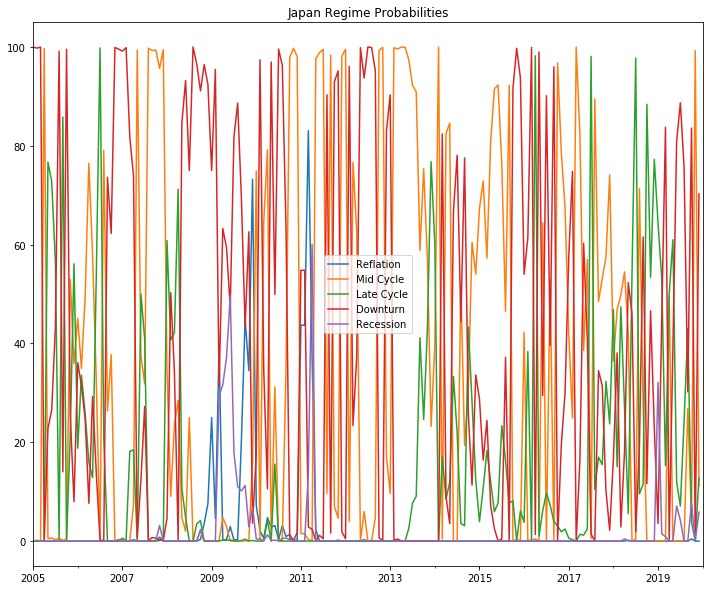

In [29]:
% matplotlib  inline


TotalProb.plot(figsize=(12,10))
plt.axis(['2005-01-01',EndDate,-5,105])
plt.title('Japan Regime Probabilities')